# Exercise 4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse
import scipy.sparse.linalg
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse.linalg as spla
from scipy.sparse import csr_matrix
from time import process_time

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

**Implement and compare the Crank-Nicolson and the ADI method for the heat equation:
\begin{equation}
\begin{cases}
u_t = u_{xx}+u_{yy}+f(x,y,t), \quad 0<x<1, \, 0<y<1, \, 0<t\leq 1,\\
u(x,y,0=u_0(x,y).
\end{cases}
\end{equation}
 with Dirichlet boundary conditions:
\begin{equation}
\begin{cases}
u(x,y,0)=x^2+y^2,\\
u(0,y,t)= (1+t)y^2,\\
u(x,0,t)=(1+t)x^2
\end{cases}
\end{equation}
and $f(x,y,t)=x^2+y^2-4(1+t)$.**

**The discussion should include the grid refinement analysis
(with a fixed final time, say T = 1, error and solution plots, comparison
of cpu time, and any conclusions you can draw from your results.**

### Cranck-Nicholson

Let's apply the CN method with discretization parameters $dt$ and $h_x=h_y=:h$ (like in class), we can write
\begin{align}
U_{i,j}^{k+1}=U_{i,j}^{k}+&\frac{\alpha}{2}\Bigr(\Bigl(U_{i+1,j}^{k}+ U_{i-1,j}^{k} + U_{i,j-1}^{k} + U_{i,j+1}^{k}-4U_{i,j}^{k}\Bigr)+\\
&\Bigl(U_{i+1,j}^{k+1}+ U_{i-1,j}^{k+1} + U_{i,j-1}^{k+1} + U_{i,j+1}^{k+1}-4U_{i,j}^{k+1}+(f_{i,j}^k+f_{i,j}^{k+1})h^2\Bigr),
\end{align}
where $\alpha := dt/h^2$ depends on the time and space discretization parameters.

Rearranging the last equation we get the linear equations
\begin{align}
2(1+2\alpha)U_{i,j}^{k+1}&-\alpha\Bigl(U_{i+1,j}^{k+1}+ U_{i-1,j}^{k+1} + U_{i,j-1}^{k+1} + U_{i,j+1}^{k+1}\Bigr)=\\
&2(1-2\alpha)U_{i,j}^{k}+\alpha\Bigl(U_{i+1,j}^{k}+ U_{i-1,j}^{k} + U_{i,j-1}^{k} + U_{i,j+1}^{k}+(f_{i,j}^k+f_{i,j}^{k+1})h^2\Bigr),
\end{align}
where (check also the code) we have $0 \leq k \leq M$ and $0 < i,j < N$ (for $i,j \in \{0,N\}$ we have the boundary conditions).

We can store all the space information on a single index, in order to work with a bidimentional matrix and not a three-dimensional array. We will use this bigger matrix to perform the computation and then we'll transform again the result into a 3D array to rescue the x and y components.

Said that, let's use the bijection $(i,j) \to l:=i+(N+1)j$, sobstituting in our equations we have
\begin{align}
2(1+2\alpha)U_l^{k+1}&-\alpha\Bigl( U_{l+1}^{k+1} + U_{l-1}^{k+1} + U_{l-(N+1)}^{k+1} + U_{l+(N+1)}^{k+1}\Bigr)=\\
&2(1-2\alpha)U_l^{k}+\alpha \Bigl( U_{l+1}^{k} + U_{l-1}^{k} + U_{l-(N+1)}^{k} + U_{l+(N+1)}^{k}+(f_l^k+f_l^{k+1})h^2\Bigr).
\end{align}

We will use these equations to define the matrix $A$ and the vector $F$ (which will depend on time i.e. k) associated to the system. To solve the latter even for large N and M we will use an algorithm of resolution for sparse matrices.

In [ ]:
### Crank-Nicolson Method ###


# square domain of latus L
L = 1
T = 1

# initial conditions
def f(x,y,t):
  return x**2+y**2-4*(1+t)

def u0(x,y):
    return x**2 + y**2

def exactsol(x,y,t):
  return (1+t)*(x**2+y**2)


# time discretization
M = 25
dt = T / M

# rewrite the approximate solution applying l -> (i,k)
def convert(U, N):
  u = np.zeros((M+1, N + 1, N + 1))
  for k in range(0, M+1):     
    for l in range(0, (N+1)**2):
      x = l % (N+1)
      y = l // (N+1)
      u[k,x,y] = U[l,k]
      #print(x, y)
  return u

In [ ]:
def error_grid(N):
    # Space discretization: grid of N x N cells in [0,1]x[0,1]
    #N = 100
    h = L / N

    # parameter
    alpha = dt/h**2
    
    t1_start = process_time() 

    # Matrix A 
    A = np.zeros(( (N+1)**2 , (N+1)**2 ))

    for i in range(0,N+1):
      for j in range(0,N+1):
        l = i+(N+1)*j
        if i == 0 or j == 0 or i == N or j == N:
          A[l,l] = 1
        else:
          A[l,l] = 2*(1+2*alpha)
          A[l,l+1] = -alpha
          A[l,l-1] = -alpha
          A[l,l+(N+1)] = -alpha
          A[l,l-(N+1)] = -alpha

    # print(A)

    A_csr = csr_matrix(A)   #rewrite A to use a resolution algorithm for sparse matrices

    # vector F(t)

    U = np.zeros(((N+1)**2 , M+1))

    #initial conditions
    for i in range(0, N+1):
      for j in range(0, N+1):
        l = i+(N+1)*j
        U[l,0] = u0(i*h,j*h)

    #determine the solution
    for k in range(1, M+1):
      F = np.zeros((N+1)**2 )        # notice F depend on time k
      for i in range(0,N+1):
        for j in range(0,N+1):
          l = i+(N+1)*j
          if i == 0 or i == N or j == 0 or j == N:    # Dirichlet boudary conditions (taken from the exact solution)
            F[l] = exactsol(i*h,j*h,k*dt)
          else:
            F[l] = 2*(1-2*alpha)*U[l, k-1] + alpha*(U[l+1, k-1] + U[l-1, k-1] + U[l+(N+1), k-1] + U[l-(N+1), k-1] + ( f(i*h,j*h,(k-1)*dt) + f(i*h,j*h,k*dt) )*h**2)
      #U[:,k] = np.linalg.solve(A,F)  # can be done faster using an algothm for sparse matrices as below
      U[:, k] = spla.dsolve.spsolve(A_csr, F)
    
    t1_stop = process_time()
    
    print("Elapsed time during the whole program in seconds (for N = ",N , "):",
                                         t1_stop-t1_start)
    
    
    #exact solution in the grid points
    exactU = np.zeros(((N+1)**2 , M+1))
    for k in range(0, M+1):       
      for i in range(0,N+1):
        for j in range(0,N+1):
          l = i+(N+1)*j
          exactU[l,k] = exactsol(i*h,j*h,k*dt)


    #Approximation error
    e = U - exactU

    err_supnorm = np.zeros(M+1)
    for k in range(0, M+1):
      err_supnorm[k] = np.linalg.norm(convert(e, N)[k],np.inf)
    
    error = np.linalg.norm(err_supnorm,np.inf)


    #print("The maximum (for each time k) for N =",N ,"of the max norm of the error is", np.linalg.norm(err_supnorm,np.inf))
    return U, error

Elapsed time during the whole program in seconds (for N =  100  ): 29.894469146000006


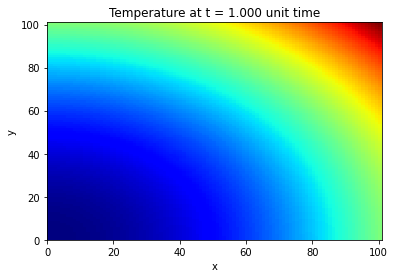

In [ ]:
U, _ = error_grid(N=100)

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")

def plotheatmap(k):
    # clear the previously added heatmaps
    ax.collections.clear()  

    # This is to plot u_k (u at time-step k)
    u_k = convert(U, N)[k]
    ax.set_title(f"Temperature at t = {k*dt:.3f} unit time")
    ax.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=4)
    #plt.colorbar()
    
def animate(k): 
    plotheatmap(k)
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=M+1)
anim

Error (calculated with infinity norm) in function of the number of grid points.

Elapsed time during the whole program in seconds (for N =  10 ): 0.0390399460000026
Elapsed time during the whole program in seconds (for N =  20 ): 0.08789432200001102
Elapsed time during the whole program in seconds (for N =  30 ): 0.2094812149999825
Elapsed time during the whole program in seconds (for N =  40 ): 0.3839373619999833
Elapsed time during the whole program in seconds (for N =  50 ): 0.6291974769999342
Elapsed time during the whole program in seconds (for N =  60 ): 0.9827282829999149
Elapsed time during the whole program in seconds (for N =  70 ): 1.4178600069999447
Elapsed time during the whole program in seconds (for N =  80 ): 1.9710082039998724
Elapsed time during the whole program in seconds (for N =  90 ): 2.6480096870000125
Elapsed time during the whole program in seconds (for N =  100 ): 31.58411297700013


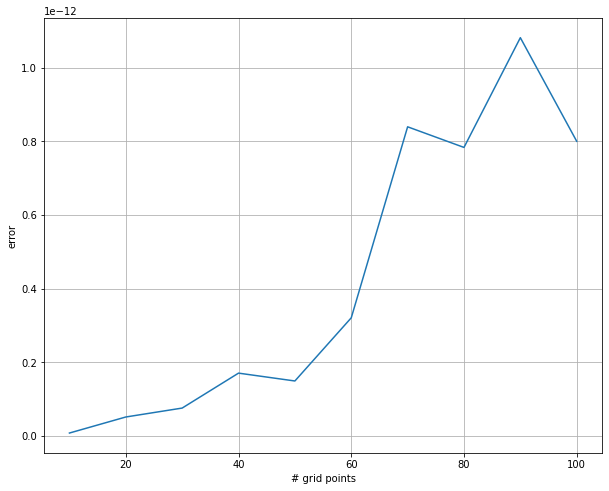

In [ ]:
NN = np.arange(10, 110, 10)
errors = []

for n in NN:
    u, er = error_grid(n)
    errors.append(er)
 
plt.figure(figsize=(10,8))
plt.plot(NN, errors)
plt.xlabel('# grid points')
plt.ylabel('error')
plt.grid()
plt.show()

### ADI

To implement the ADI method we divide the domain as follows: the $x$ axis into $N$ intervals of length $h_x$, the $x$ axis into $n$ intervals of length $h_y$,and we discretize the time interval $[0,1]$ with $M$ intervals of length $dt$.

For a generic $0<i<N,$ $0<i<n,$ and $0<k<M-1,$ the ADI method gives

$$
\frac{U^{k+1}_{i,j}-U^{k}_{i,j}}{dt}=\frac{U^{k+1}_{i-1,j}-2U^{k+1}_{i,j}+U^{k+1}_{i,j}}{h_x^2}+\frac{U^{k}_{i-1,j}-2U^{k}_{i,j}+U^{k}_{i,j}}{h_y^2}+f_{i,j}^k
$$
$$
\frac{U^{k+2}_{i,j}-U^{k+1}_{i,j}}{dt}=\frac{U^{k+1}_{i-1,j}-2U^{k+1}_{i,j}+U^{k+1}_{i,j}}{h_x^2}+\frac{U^{k+2}_{i-1,j}-2U^{k+2}_{i,j}+U^{k+2}_{i,j}}{h_y^2}+f_{i,j}^{k+1}
$$

In [ ]:
def grid_grid(N, n):
    # Space discretization: grid of N x n cells in [0,1]x[0,1]
    #N = 20
    hx = L / N
    #n = 18
    hy = L / n
    
    t1_start = process_time()

    # Matrices A[j] 
    A = np.zeros((n+1, N+1, N+1))
    for j in range(0,n+1):
      for i in range(0,N+1):
        if i == 0 or i == N:
          A[j,i,i] = 1
        else:
          A[j,i,i-1] = 1
          A[j,i,i] = -(2+hx**2/dt)
          A[j,i,i+1] = 1

    #print(A[1])

    # Matrices B[i]
    B = np.zeros((N+1, n+1, n+1))
    for i in range(0,N+1):
      for j in range(0,n+1):
        if j == 0 or j == n:
          B[i,j,j] = 1
        else:
          B[i,j,j-1] = 1
          B[i,j,j] = -(2+hy**2/dt)
          B[i,j,j+1] = 1

    # approximate solution
    U = np.zeros((M+1, N+1 , n+1))

    #initial condition
    for i in range(0,N+1):
      for j in range(0,n+1):
        U[0,i,j] = u0(i*hx,j*hy)


    # resolution algorithm
    for k in range(1,M+1):
      if k % 2 == 0: #use A
        for j in range(0,n+1):
           if j == 0 or j == n:
            for i in range(0,N+1):
              U[k,i,j] = exactsol(i*hx,j*hy,k*dt) # Dirichlet boundary condition on  y=0 and y=1
           else:
              F = np.zeros(N+1)
              for i in range(0,N+1):
                if i == 0 or i == N or j == 0 or j == n:
                  F[i] = exactsol(i*hx,j*hy,k*dt)  #Dirichlet boundary condition (derived by the exact solution)
                else:
                  F[i] = (2*(hx**2)/(hy**2)-hx**2/dt)*U[k-1,i,j]-(hx**2)/(hy**2)*(U[k-1,i,j-1] + U[k-1,i,j+1]) - (hx**2)*f(i*hx,j*hy,k*dt)
              U[k,:,j] = np.linalg.solve(A[j,:,:],F)
      elif k % 2 == 1: #use B
        for i in range(0,N+1):
          if i == 0 or i == N:
            for j in range(0,n+1):
              U[k,i,j] = exactsol(i*hx,j*hy,k*dt) # Dirichlet boundary condition on  x=0 and x=1
          else:
            G = np.zeros(n+1)
            for j in range(0,n+1):
              if i == 0 or i == N or j == 0 or j == n:
                G[j] = exactsol(i*hx,j*hy,k*dt)  #Dirichlet boundary condition (derived by the exact solution)
              else:
                G[j] = (2*(hy**2)/(hx**2)-hy**2/dt)*U[k-1,i,j]-(hy**2)/(hx**2)*(U[k-1,i-1,j] + U[k-1,i+1,j]) - (hy**2)*f(i*hx,j*hy,(k-1)*dt)
            U[k,i,:] = np.linalg.solve(B[i,:,:],G)
        
    t1_stop = process_time()
    
    print("Elapsed time during the whole program in seconds (for N = ",N , "and n = ", n, "):",
                                         t1_stop-t1_start)
            
    # exact solution in the grid points
    exactU = np.zeros((M+1, N+1 , n+1))
    for k in range(0,M+1):
        for j in range(0,n+1):
          for i in range(0,N+1):
            exactU[k,i,j] = exactsol(i*hx,j*hy,k*dt)

    #Approximation error
    err = U - exactU

    err_supnorm = np.zeros(M+1)
    for k in range(0, M+1):
      err_supnorm[k] = np.linalg.norm(err[k],np.inf)

    #print(err[0])
    err = np.linalg.norm(err_supnorm,np.inf)

    #print("The maximum (for each time k) of the max norm of the error is", np.linalg.norm(err_supnorm,np.inf))
    return U, err

Elapsed time during the whole program in seconds (for N =  20 and n =  18 ): 1.3675407649999443


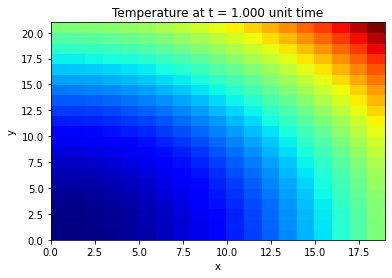

In [ ]:
U, _ = grid_grid(N=20, n=18)

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")

def plotheatmap(k):
    # clear the previously added heatmaps
    ax.collections.clear()

    # This is to plot u_k (u at time-step k)
    u_k = U[k]#convert(U, N)[k]
    ax.set_title(f"Temperature at t = {k*dt:.3f} unit time")
    ax.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=4)
    #fig.colorbar(im)
    
def animate(k): 
    plotheatmap(k)
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=M+1)
anim

In [ ]:
NN = np.arange(10, 21, 1)
errors = np.zeros((11, 11))
i=0
for N in NN:
    j=0
    for n in NN:
        U, err = grid_grid(N, n)
        errors[i, j] = err
        j+=1
    i+=1

Elapsed time during the whole program in seconds (for N =  10 and n =  10 ): 0.041412963000084346
Elapsed time during the whole program in seconds (for N =  10 and n =  11 ): 0.030887886000073195
Elapsed time during the whole program in seconds (for N =  10 and n =  12 ): 0.026293471000030877
Elapsed time during the whole program in seconds (for N =  10 and n =  13 ): 0.021313724000037837
Elapsed time during the whole program in seconds (for N =  10 and n =  14 ): 0.021428076000006513
Elapsed time during the whole program in seconds (for N =  10 and n =  15 ): 0.023998117000019192
Elapsed time during the whole program in seconds (for N =  10 and n =  16 ): 0.026340215999994143
Elapsed time during the whole program in seconds (for N =  10 and n =  17 ): 0.6288561540000046
Elapsed time during the whole program in seconds (for N =  10 and n =  18 ): 0.9957631080000056
Elapsed time during the whole program in seconds (for N =  10 and n =  19 ): 0.9539669419999655
Elapsed time during the wh

Elapsed time during the whole program in seconds (for N =  17 and n =  18 ): 1.7845160510000824
Elapsed time during the whole program in seconds (for N =  17 and n =  19 ): 1.9320375429999785
Elapsed time during the whole program in seconds (for N =  17 and n =  20 ): 1.4919843380000657
Elapsed time during the whole program in seconds (for N =  18 and n =  10 ): 0.8929009529999803
Elapsed time during the whole program in seconds (for N =  18 and n =  11 ): 1.1204747599999791
Elapsed time during the whole program in seconds (for N =  18 and n =  12 ): 0.9894891410000355
Elapsed time during the whole program in seconds (for N =  18 and n =  13 ): 1.4029481159999477
Elapsed time during the whole program in seconds (for N =  18 and n =  14 ): 0.9662320289999116
Elapsed time during the whole program in seconds (for N =  18 and n =  15 ): 1.8798651089999794
Elapsed time during the whole program in seconds (for N =  18 and n =  16 ): 1.8736604419999594
Elapsed time during the whole program in

Error (calculated using infinity norm) in fuction of the cell size

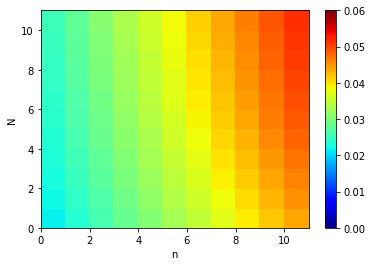

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("n")
ax.set_ylabel("N")
im = ax.pcolormesh(errors, cmap=plt.cm.jet, vmin=0, vmax=0.06)
fig.colorbar(im)

- We observe that the error committed by the CN method is much smaller than the one resulting by ADI (the first is $O(10^{-12})$ while the second $O(10^{-2})$.